dataset  
- amazon review
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

- chABSA
https://github.com/chakki-works/chABSA-dataset


https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

install mecab and neologd if you use Japanese.

install mecab on mac
```
brew install mecab mecab-ipadic  
pip install mecab-python3
```
install neologd
```
git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
cd mecab-ipadic-neologd
./bin/install-mecab-ipadic-neologd -n
```

In [ ]:
!sudo apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab

In [ ]:
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git

In [ ]:
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n

In [ ]:
!pip install mecab-python3 tqdm

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import sys
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
from numpy.random import choice, randint
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
from util import load_data_and_labels, get_parser


 
%matplotlib inline
%load_ext jupyternotify

build Tokenizer
get stopwords from the web site.
Japanese stopword:  あそこ, あたり, あちら ...
English stopword: ... you've, z, zero


<IPython.core.display.Javascript object>

In [2]:
class TextCNN:

    def __init__(
        self, sequence_length, num_classes, vocab_size, embedding_size, 
        filter_sizes, num_filters, l2_reg_lambda=0.0):
        print("# classes", num_classes)


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")
        self.loss_weight = tf.placeholder(tf.float32, name="loss_ratio")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                bn_conv = self.batch_normalization(conv) 
                h = tf.nn.relu(tf.nn.bias_add(bn_conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                pooled_outputs.append(pooled)


        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        

        with tf.name_scope("fc-1"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, 1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(self.h_pool_flat, W, b), name="fc-1-out")


        with tf.name_scope("dropout-1"):
            drop_1 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)


        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([1024,1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop_1, W, b), name="fc-2-out")
            
        with tf.name_scope("dropout-2"):
            drop_2 = tf.nn.dropout(fc_2_output, self.dropout_keep_prob)


        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(drop_2, W, b, name="output")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
            
        with tf.name_scope("loss"):
      
            #　targets * -log(sigmoid(logits)) * pos_weight +　(1 - targets) * -log(1 - sigmoid(logits))
            losses = tf.nn.weighted_cross_entropy_with_logits(logits=self.scores, targets=self.input_y, pos_weight=self.loss_weight)
            #losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy") 
            
            
    def batch_normalization(self, x):
        """
          x -> γ(x-μ)/√（σ^2-ε）　+ β
      
          γ : scale
          μ: mean (first moment)
          σ: variance (second moment)
          β: offset
          ε: to avoid dividing by 0
        """
        epsilon = 1e-5
        dim = x.get_shape()[-1]
        scale = tf.Variable(tf.ones([dim]))
        offset = tf.Variable(tf.zeros([dim]))
        mean, variance = tf.nn.moments(x, [0,1,2])
        return tf.nn.batch_normalization(x, mean, variance, offset, scale, epsilon)

In [3]:
#positive_data_file = "data/amazon/book_pos.txt"
#negative_data_file = "data/amazon/book_neg.txt"

#positive_data_file = "data/chABSA/pos.txt"
#negative_data_file = "data/chABSA/neg.txt"

positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

In [4]:
files = ["data/amazon_ja/r_{}.txt".format(i) for i in range(1,6)]

In [5]:
class Tokenizer:
    def __init__(self, parser=None):
        if parser:
            self.parser = parser
        else:
            self.parser = get_parser()
            

    def tokenize(self, text):
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = " ".join([i[2] for i in l if len(i) >=4]) # has POS.)
        return res

In [6]:
t = Tokenizer()
t.tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

'認める たい ない もの だ な 。 自分自身 の 若さ故の過ち という もの を 。'

In [11]:
%%notify
level= "char"
x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level=level, lang="Ja", tokenizer=t)

start to load data and labels.
# pos:  62402
# neg:  9060
pos/neg: 6.887637969094922


<IPython.core.display.Javascript object>

In [12]:
long_doc = True

In [13]:
len(x_text)

71462

In [14]:
x_text[0][:100]

' 書 き 込 み 、 読 み 出 し 、 転 送 速 度 、 い ず れ も 満 足 で す 。 1 6 0 0 万 画 素 の コ ン パ ク ト カ メ ラ タ イ プ の デ ジ カ メ に 入'

In [15]:
length_list = np.array([len(r)for r in x_text])

In [16]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,549
1,67
2,179
3,227
4,311


In [17]:
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

,length
count,71462.000000
mean,251.363746
std,328.850754
min,7.000000
50%,171.000000
75%,289.000000
80%,329.000000
90%,471.000000
95%,669.000000
max,17495.000000


In [18]:
#df.quantile(0.95)["length"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c550dd2b0>]],
      dtype=object)

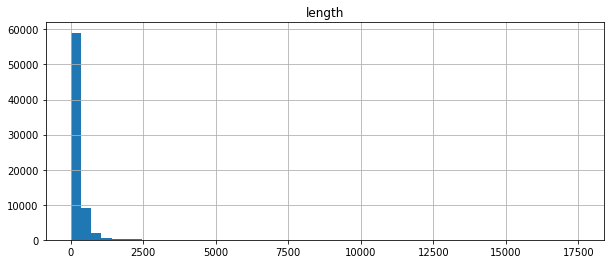

In [19]:
df.hist(bins=50,figsize=(10,4))

In [20]:
max_length = int(df.quantile(0.9)["length"]) #1000
if long_doc:
    print("cut length to ", max_length)
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

cut length to  471


,length
count,71462.000000
mean,210.610730
std,128.956019
min,7.000000
50%,171.000000
75%,289.000000
80%,329.000000
90%,471.000000
95%,471.000000
max,471.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c89746f98>]],
      dtype=object)

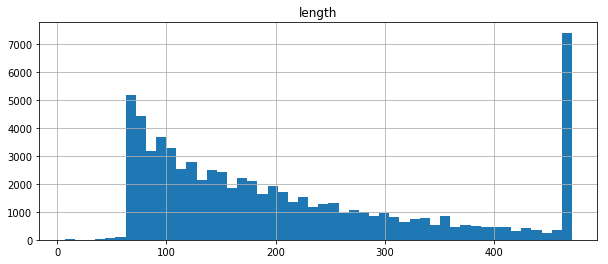

In [21]:
df.hist(bins=50,figsize=(10,4))

In [22]:
vocab_processor = preprocessing.VocabularyProcessor(max_length)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [23]:
len(x_text)

71462

In [24]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


<IPython.core.display.Javascript object>

In [29]:
test_percentage = 0.03 #0.0010 #0.1

In [30]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 3215
Train/Test split: 69319/2143


<IPython.core.display.Javascript object>

In [31]:
print(x_train.shape)

(69319, 471)


In [32]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [33]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [37]:
embedding_size = 128    
filter_sizes = [2,3,4,5,6]    
num_filters =128               
dropout_keep_prob = 0.5 
l2_reg_lambda = 0.01       

In [38]:
TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)

# classes 2


In [39]:
batch_size = 64                  
num_epochs = 30            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True

In [40]:
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
out_dir = os.path.join(os.path.curdir, "runs", "{}_cnn_{}".format(level,num_classes), time_path, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/char_cnn_2/2018_07_22_22_48_46/



In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        test_summary_op = tf.summary.merge([loss_summary, acc_summary])
        test_summary_dir = os.path.join(out_dir, "summaries", "test")
        test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob,
              cnn.loss_weight: 1.0#ratio
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            time_str = datetime.datetime.now().isoformat()
            if step % 20 == 0:
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def test_step(x_batch, y_batch, writer=None):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0,
              cnn.loss_weight: 1.0
            }
            step, summaries, loss, accuracy = sess.run([global_step, test_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                test_step(x_test, y_test, writer=test_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

# classes 2
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/hist is illegal; using conv-maxpool-2/Variable_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/sparsity is illegal; using conv-maxpool-2/Variable_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-ma

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/char_cnn_2/2018_07_22_22_48_46/checkpoints/model-140

2018-07-22T22:53:13.960903: step 160, loss 0.393938, acc 0.859375

Evaluation:
2018-07-22T22:53:28.267615: step 160, loss 0.366669, acc 0.875875

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/char_cnn_2/2018_07_22_22_48_46/checkpoints/model-160

2018-07-22T22:53:48.069683: step 180, loss 0.440399, acc 0.859375

Evaluation:
2018-07-22T22:53:58.730515: step 180, loss 0.373926, acc 0.875875

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/char_cnn_2/2018_07_22_22_48_46/checkpoints/model-180

2018-07-22T22:54:19.422966: step 200, loss 0.386632, acc 0.875

Evaluation:
2018-07-22T22:54:35.159030: step 200, loss 0.364038, acc 0.875875

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/char_cnn_2/2018_07_22_22_48_46/checkpoints/model-200

2018-07-22T22:54:56.863546: step 220, loss 0.349556, acc 0.890625

Evalua

##char level cnn 
- 1525408577  
- 1526189751 chABSA  good
- 1523936751 amazon good
- 2018_05_17_12_10_17 chABSA max_length 300
- 2018_07_07_10_13_49 amazon_ja

##word level cnn 
- 2018_05_17_12_46_51chABSA
- 2018_07_07_13_04_25 amazon_ja

In [ ]:
#out_dir = os.path.join(os.path.curdir, "runs", "2018_05_17_12_10_17", prefix)

In [ ]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path

In [ ]:
def check_neg_posi(text):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
              allow_soft_placement=allow_soft_placement,
              log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, latest_ckpt)
        
            text = [s.replace(" ", "").replace("", " ").lower() for s in [text]]
            x = np.array(list(vocab_processor.fit_transform(text)))
            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            sess.run(tf.global_variables_initializer())
            feature_2 = sess.run(cnn.scores, feed_dict=feed_dict)
    print(feature_2[0])
    if np.argmax(feature_2[0]):
        print("positive")
    else:
        print("negative")

In [ ]:
check_neg_posi("当四半期連結累計期間の営業利益は、前年同期比5,184億円増加し、7,127億円となりました。この大幅な増益は、主に半導体分野の大幅な損益改善及び前年同期に映画分野の営業権の減損損失を計上していたことによるものです。 ")

In [ ]:
check_neg_posi("伸び率は減少傾向にありました。")

In [ ]:
check_neg_posi("伸び率は加向にありました。")

In [ ]:
check_neg_posi("伸び率は減向にありました。")

In [ ]:
def eval_acc(x, y, max_length):
    with tf.Graph().as_default():
        with tf.Session() as sess:
            cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            
            saver.restore(sess, latest_ckpt)
        
            feed_dict = {
              cnn.input_x: x,
              cnn.input_y: y,
              cnn.dropout_keep_prob: 1.0
            }
            acc, scores = sess.run([cnn.accuracy, cnn.scores], feed_dict=feed_dict)
    return acc, scores

In [ ]:
max_length

In [ ]:
def drop_char(x_test ,n):
    drop_x_test = []
    for x in  x_test:
        x_c = x.copy()
        for i in choice(range(max_length), n,replace=False):
            x_c[i] = randint(max_length)
        drop_x_test.append(x_c)
    return drop_x_test

In [ ]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
a

In [ ]:
a,s = eval_acc(drop_char(x_test, 100), y_test, max_length=max_length)
a

In [ ]:
r = []
for i in tqdm(range(max_length)):
    a,s = eval_acc(drop_char(x_test, i), y_test, max_length=max_length)
    print(a)
    r.append(a)

In [ ]:
plt.plot(range(max_length), r)
plt.show()

word level

In [ ]:
def create_drop_doc(positive_data_file, negative_data_file, n):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    po = []
    ne = []
    t = Tokenizer()
    for e in positive_examples:
        if len(e) < n:
            e_ = ""
            for _ in  range(len(e)):
                e_ += chr(randint(12354, 20000)) + " "
            e = e_
        else:
            max_n = n
            for i in choice(range(len(e)), max_n, replace=False):
                e = e.replace(e[i], chr(randint(12354, 20000)))
        po.append(t.tokenize(e))
        
    for e in negative_examples:
        if len(e) < n:
            e = "{} ".format(chr(randint(12354, 20000))) * len(e)
        else:
            max_n = n
            for i in choice(range(len(e)), max_n, replace=False):
                e = e.replace(e[i], chr(randint(12354, 20000)))
        ne.append(t.tokenize(e))

   
    positive_examples = po
    negative_examples = ne
        
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    #return po, y
    return x_text, y

In [ ]:
x_, y_ = create_drop_doc(positive_data_file, negative_data_file, 300)

In [ ]:
x_[1]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_)))

In [ ]:
x = x[shuffle_indices][test_sample_index:]

In [ ]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
a

In [ ]:
a,s = eval_acc(x, y_test, max_length=max_length)
a

In [ ]:
r = []
for i in tqdm(range(max_length)):
    x_, y_ = create_drop_doc(positive_data_file, negative_data_file, i)
    x = np.array(list(vocab_processor.fit_transform(x_)))
    x = x[shuffle_indices][test_sample_index:]
    a,s = eval_acc(x, y_test,max_length=max_length)
    print(a)
    r.append(a)

In [ ]:
plt.plot(range(max_length), r)
plt.show()

In [ ]:
a,s = eval_acc(drop_char(), y_test, max_length=max_length)
a

In [ ]:
#out_dir="runs/1523936751"

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
    with sess.as_default():
        cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, latest_ckpt)
        #sess.run(tf.global_variables_initializer())
        w = sess.run(cnn.W, feed_dict={cnn.input_x: x_test})

In [ ]:
w

In [ ]:
w.shape

In [ ]:
with open('embedding_tensor.tsv','w') as f:
    for char_vec in w:
        for weight in char_vec:
            f.write(str(weight)+ "\t")
        f.write("\n")

In [ ]:
#vocab_dict = vocab_processor.vocabulary_._mapping
vocab_dict = vocab_processor.vocabulary_._reverse_mapping

In [ ]:
vocab_dict[1]

In [ ]:
with  open('embedding_metadata.tsv' ,'w') as f:
    f.write('Titles\tGenres\n')
    for i,v in enumerate(w):
        f.write("%s\t%s\n" % (vocab_dict[i], vocab_dict[i]))

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, latest_ckpt)

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_text)))